In [ ]:

!pip install opencv-python tensorflow

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import os
from PIL import Image
import os

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, UpSampling2D, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.vgg16 import preprocess_input
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score, accuracy_score
import numpy as np
import pandas as pd
import cv2
import random
from tqdm import tqdm
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:

normal_dir= '/content/drive/MyDrive/train/NORMAL'
normal_img = [f for f in os.listdir(normal_dir) if os.path.isfile(os.path.join(normal_dir, f))]
normal_img[:10]


['IM-0523-0001-0001.jpeg',
 'IM-0523-0001.jpeg',
 'IM-0511-0001.jpeg',
 'IM-0526-0001.jpeg',
 'IM-0513-0001.jpeg',
 'IM-0531-0001.jpeg',
 'IM-0536-0001.jpeg',
 'IM-0530-0001.jpeg',
 'IM-0527-0001.jpeg',
 'IM-0531-0001-0001.jpeg']

In [ ]:
print(len(normal_img))

1341


In [ ]:
pneumonia_dir = '/content/drive/MyDrive/train/PNEUMONIA'
pneumonia_img = [f for f in os.listdir(pneumonia_dir) if os.path.isfile(os.path.join(pneumonia_dir, f))]
pneumonia_img = pneumonia_img[:1341]
pneumonia_img[:10]

['person541_bacteria_2275.jpeg',
 'person540_bacteria_2272.jpeg',
 'person541_virus_1071.jpeg',
 'person541_bacteria_2274.jpeg',
 'person539_virus_1069.jpeg',
 'person543_bacteria_2279.jpeg',
 'person543_bacteria_2282.jpeg',
 'person53_bacteria_255.jpeg',
 'person537_bacteria_2264.jpeg',
 'person537_bacteria_2265.jpeg']

In [ ]:
print(len(pneumonia_img))

1341


In [ ]:
import numpy as np
import pandas as pd
import cv2
import random
from tqdm import tqdm
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
from tensorflow.keras.preprocessing.image import load_img,img_to_array
image_size=224
labels = []
dataset = []
def create_dataset(image_category,label):
    for img in tqdm(image_category):
        if label == 1:
            image_path = os.path.join(pneumonia_dir, img)
        else:
            image_path = os.path.join(normal_dir, img)

        try:
            image = cv2.imread(image_path,cv2.IMREAD_COLOR)
            image = cv2.resize(image,(image_size,image_size))
        except:
            continue

        dataset.append([np.array(image),np.array(label)])
    random.shuffle(dataset)
    return dataset

In [ ]:
dataset = create_dataset(pneumonia_img,1)

100%|██████████| 1341/1341 [00:59<00:00, 22.50it/s] 


In [ ]:
len(dataset)

1341

In [ ]:
dataset = create_dataset(normal_img,0)

100%|██████████| 1341/1341 [00:36<00:00, 36.81it/s]


In [ ]:
len(dataset)

2682

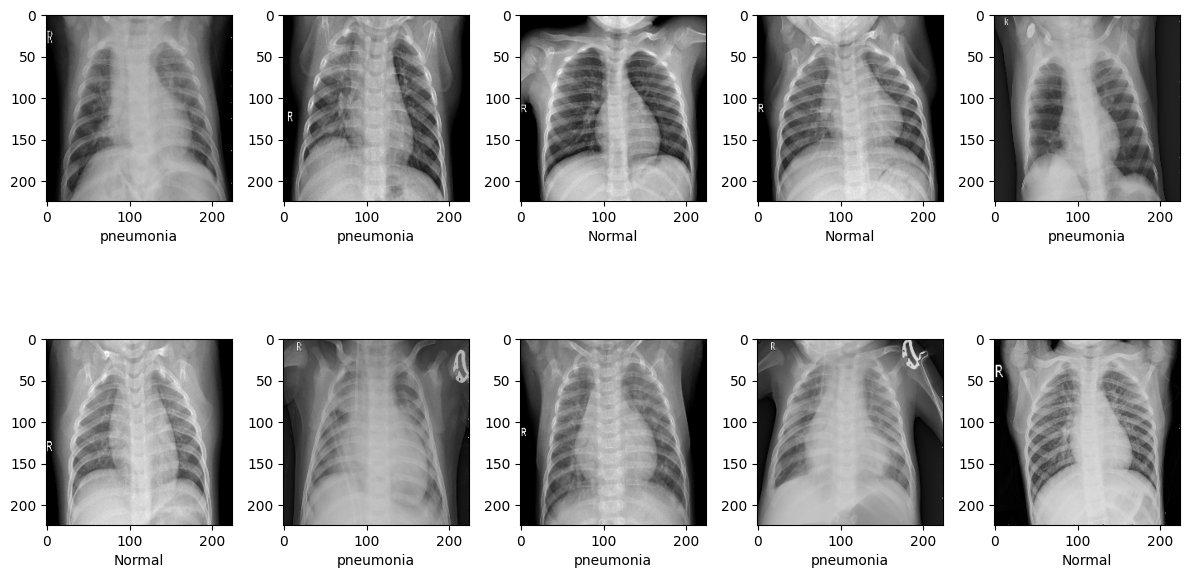

In [ ]:
plt.figure(figsize=(12,7))
for i in range(10):
    sample = random.choice(range(len(dataset)))
    image = dataset[sample][0]
    category = dataset[sample][1]
    if category== 0:
        label = "Normal"
    else:
        label = "pneumonia"
    plt.subplot(2,5,i+1)
    plt.imshow(image)
    plt.xlabel(label)
plt.tight_layout()

In [ ]:
x = np.array([i[0] for i in dataset]).reshape(-1,image_size,image_size,3)
y = np.array([i[1] for i in dataset])
x=x/255

In [ ]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2,stratify=y)

In [ ]:
from tensorflow.keras.applications.vgg19 import VGG19
vgg = VGG19(weights="imagenet",include_top = False,input_shape=(image_size,image_size,3))

In [ ]:
for layer in vgg.layers:
    layer.trainable = False

In [ ]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten,Dense
model = Sequential()
model.add(vgg)
model.add(Flatten())
model.add(Dense(1,activation="sigmoid"))

In [ ]:
model.compile(optimizer="adam",loss="binary_crossentropy",metrics=["accuracy"])

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

checkpoint = ModelCheckpoint("vgg.keras", monitor="val_accuracy", verbose=1, save_best_only=True, save_weights_only=False, save_freq='epoch')
earlystop = EarlyStopping(monitor="val_accuracy", patience=10, verbose=1)

In [ ]:
history = model.fit(x_train,y_train,batch_size=32,epochs=20,validation_data=(x_test,y_test),
                    verbose=1,callbacks=[checkpoint,earlystop])

Epoch 1/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step - accuracy: 0.7784 - loss: 0.4821
Epoch 1: val_accuracy improved from -inf to 0.96648, saving model to vgg.keras
68/68 ━━━━━━━━━━━━━━━━━━━━ 45s 431ms/step - accuracy: 0.7799 - loss: 0.4792 - val_accuracy: 0.9665 - val_loss: 0.1157
Epoch 2/20
67/68 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 0.9721 - loss: 0.1003
Epoch 2: val_accuracy improved from 0.96648 to 0.97579, saving model to vgg.keras
68/68 ━━━━━━━━━━━━━━━━━━━━ 51s 187ms/step - accuracy: 0.9719 - loss: 0.1004 - val_accuracy: 0.9758 - val_loss: 0.0788
Epoch 3/20
67/68 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - accuracy: 0.9858 - loss: 0.0702
Epoch 3: val_accuracy improved from 0.97579 to 0.97952, saving model to vgg.keras
68/68 ━━━━━━━━━━━━━━━━━━━━ 23s 219ms/step - accuracy: 0.9856 - loss: 0.0704 - val_accuracy: 0.9795 - val_loss: 0.0685
Epoch 4/20
67/68 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - accuracy: 0.9803 - loss: 0.0664
Epoch 4: val_accuracy did not improve from 0.97952
68/68 ━━

In [ ]:
loss,accuracy = model.evaluate(x_test,y_test)
print("loss:",loss)
print("Accuracy:",accuracy)

17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 146ms/step - accuracy: 0.9897 - loss: 0.0325
loss: 0.04332266002893448
Accuracy: 0.9832402467727661


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_confusion_matrix
y_pred_prob = model.predict(x_test)
y_pred = (y_pred_prob > 0.5).astype(int)
print(classification_report(y_test,y_pred))

17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 184ms/step
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       269
           1       0.99      0.97      0.98       268

    accuracy                           0.98       537
   macro avg       0.98      0.98      0.98       537
weighted avg       0.98      0.98      0.98       537



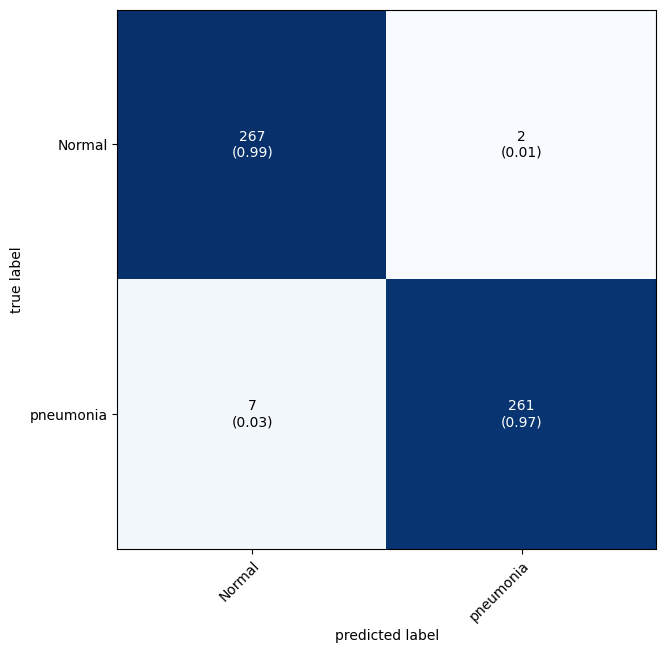

In [ ]:
!pip install mlxtend
from mlxtend.plotting import plot_confusion_matrix
cm = confusion_matrix(y_test,y_pred)
plot_confusion_matrix(conf_mat = cm,figsize=(8,7),class_names = ["Normal","pneumonia"],
                      show_normed = True);

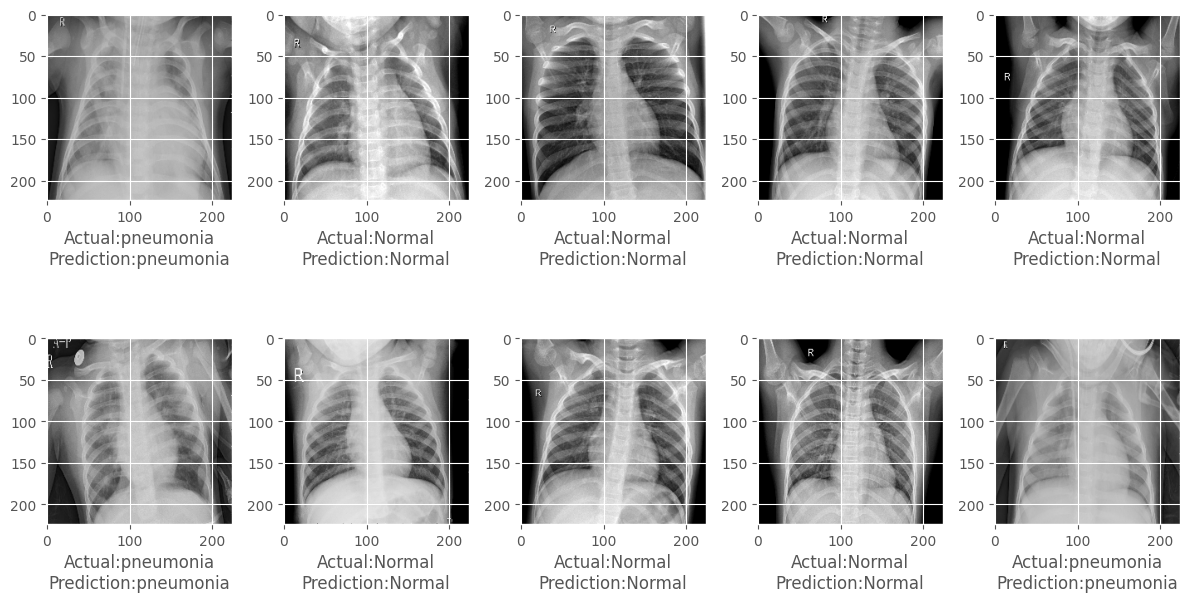

In [ ]:
plt.figure(figsize=(12,7))
for i in range(10):
    sample = random.choice(range(len(x_test)))
    image = x_test[sample]
    category = y_test[sample]
    pred_category = y_pred[sample]

    if category== 0:
        label = "Normal"
    else:
        label = "pneumonia"

    if pred_category== 0:
        pred_label = "Normal"
    else:
        pred_label = "pneumonia"

    plt.subplot(2,5,i+1)
    plt.imshow(image)
    plt.xlabel("Actual:{}\nPrediction:{}".format(label,pred_label))
plt.tight_layout()

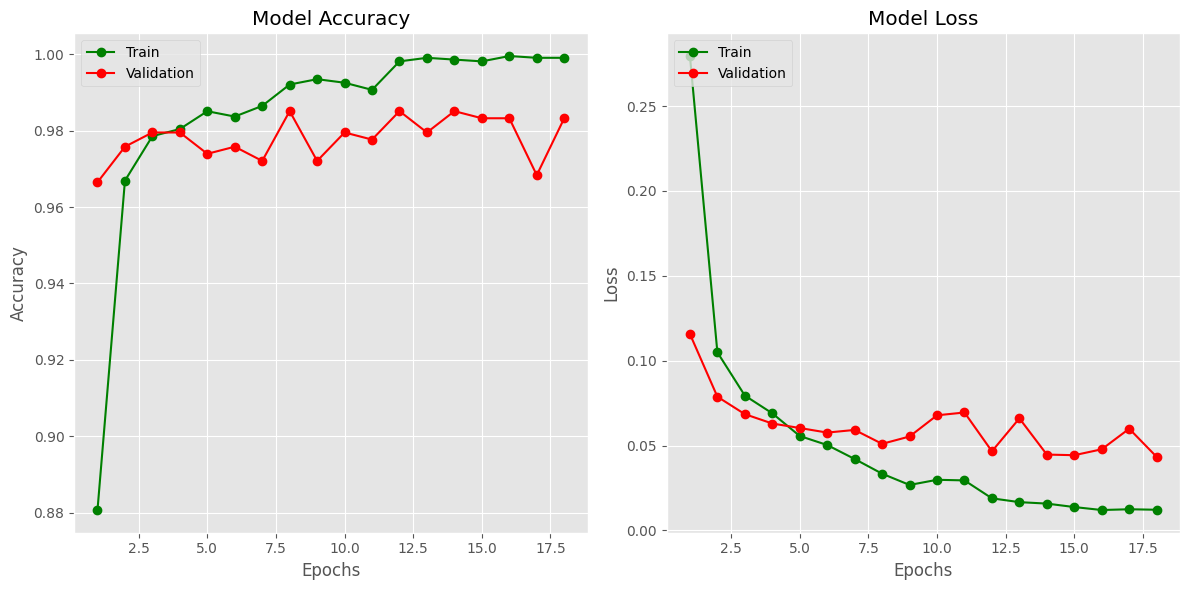

In [ ]:
plt.style.use("ggplot")
fig = plt.figure(figsize=(12, 6))

epochs = range(1, len(history.history['accuracy']) + 1)

plt.subplot(1, 2, 1)
plt.plot(epochs, history.history["accuracy"], "go-", label="Train")
plt.plot(epochs, history.history["val_accuracy"], "ro-", label="Validation")
plt.title("Model Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(loc="upper left")

plt.subplot(1, 2, 2)
plt.plot(epochs, history.history["loss"], "go-", label="Train")
plt.plot(epochs, history.history["val_loss"], "ro-", label="Validation")
plt.title("Model Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(loc="upper left")

plt.tight_layout()
plt.show()
